# Interpret Reactions with Howso Engine

## Overview

This notebook provides an overview of applying Howso Engine to make predictions based on trained data and harnessing Howso Engine’s interpretability capabilities to understand why the predictions were made. Here, we demonstrate these capabilities on asteroid data. We build a Howso Engine Trainee to predict various information about different asteroids, understand the influential cases on the predictions, and understand the uncertainty of the predictions. This is a straightforward example of the power of Howso Engine to gain insights from data. 

In [1]:
import os

import pandas as pd
import plotly.io as pio

from howso.engine import Trainee
from howso.utilities import infer_feature_attributes
from howso.visuals import plot_interpretable_prediction

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

## Step 1: Load the Data

For this demonstration we will use a subset of a dataset containing measurements of various asteroids

In [2]:
dataset_path = "../../../data/asteroid.csv"
df_full = pd.read_csv(dataset_path, low_memory=False)
header = list(df_full)
df = df_full.truncate(after=5000)
df = df.where(df.notnull(), None)

df

,full_name,a,e,G,i,om,w,q,ad,per_y,...,rot_per,GM,BV,UB,IR,spec_B,spec_T,neo,pha,moid
0,1 Ceres,2.769165,0.076009,0.12,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,...,9.074170,62.6284,0.713,0.426,NaN,C,G,N,N,1.594780
1,2 Pallas,2.772466,0.230337,0.11,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,...,7.813200,14.3000,0.635,0.284,NaN,B,B,N,N,1.233240
2,3 Juno,2.669150,0.256942,0.32,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,...,7.210000,NaN,0.824,0.433,NaN,Sk,S,N,N,1.034540
3,4 Vesta,2.361418,0.088721,0.32,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,...,5.342128,17.8000,0.782,0.492,NaN,V,V,N,N,1.139480
4,5 Astraea,2.574249,0.191095,NaN,5.366988,141.576604,358.687608,2.082324,3.066174,4.130323,...,16.806000,NaN,0.826,0.411,NaN,S,S,N,N,1.095890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,4997 Ksana (1986 TM),2.871173,0.329960,NaN,32.732948,10.726564,57.718579,1.923802,3.818544,4.865161,...,3.434200,NaN,NaN,NaN,NaN,B,None,N,N,1.058150
4997,4998 Kabashima (1986 VG),3.007439,0.073460,NaN,9.904038,352.226415,100.901739,2.786511,3.228367,5.215590,...,6.138000,NaN,NaN,NaN,NaN,None,None,N,N,1.824890
4998,4999 MPC (1987 CJ),3.015442,0.040212,NaN,10.473593,155.933107,344.673442,2.894184,3.136701,5.236423,...,NaN,NaN,NaN,NaN,NaN,None,None,N,N,1.907750
4999,5000 IAU (1987 QN7),2.537905,0.263911,NaN,6.265176,150.922214,232.797213,1.868123,3.207687,4.043163,...,NaN,NaN,NaN,NaN,NaN,None,None,N,N,0.878287


## Step 2: Define and verify the feature attributes

We use `infer_feature_attributes` to define feature attributes for our dataset, then print out the feature attributes to ensure they are correct.

In [3]:
features = infer_feature_attributes(df)

features

{'full_name': {'type': 'nominal',
  'original_type': {'data_type': 'string'},
  'bounds': {'allow_null': True}},
 'a': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 9,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 0.367879441, 'max': 20.085536923, 'allow_null': True}},
 'e': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 9,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 0.002478752, 'max': 1.0, 'allow_null': True}},
 'G': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 2,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': -0.14, 'max': 1.0, 'allow_null': True}},
 'i': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 9,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 0.049787068, 'max': 148.413159103, 'allow_null': True}},
 'om': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places':

## Step 3: Create and Train a Trainee

As is the usual Howso Engine workflow: We create a Trainee, then train and analyze.

In [4]:
action_feature = ['moid']
context_features = features.get_names(without=['moid'])

trainee = Trainee(name='Engine - Interpretable Predictions Recipe', features=features, overwrite_existing=True)

trainee.train(df)

trainee.analyze()

## Step 4: React

First, we'll select one case to react to for demonstration purposes. 

This case is selected from the cases which were **_not_** trained, so the model does not know about this case in particular.

In [5]:
predict_index = 200001

df_full = df_full.astype(object)
df_full = df_full.where(df_full.notnull(), None) # convert NaN to None
case = df_full[predict_index:predict_index+1].iloc[0]  # grab a case that wasn't trained
context_values = case.iloc[0:26].tolist()
action_value = case.iloc[26]

In [6]:
df_full[predict_index:predict_index+1]

,full_name,a,e,G,i,om,w,q,ad,per_y,...,rot_per,GM,BV,UB,IR,spec_B,spec_T,neo,pha,moid
200001,200002 Hehe (2007 JZ43),2.409757,0.158912,None,6.959368,116.592076,198.714295,2.026818,2.792696,3.740831,...,None,None,None,None,None,None,None,N,N,1.01338


### Next, we react.

When we call `react`, we include a request for certain `details`. Namely, `influential cases`. This will retrieve all of the cases which influenced the prediction and return them alongside the prediction itself. These can be used to interpret the prediction.

In [7]:
react = trainee.react(context_features=context_features,
                      action_features=action_feature,
                      contexts=[context_values],
                      details = {
                          'influential_cases': True,
                          'feature_residuals': True
                      })


print('Predicted action feature:')
display(react['action'])

local_residual = react['details']['feature_residuals'][0][action_feature[0]]
print('Local MAE of action feature:')
display(local_residual)

print('Computed explanation: ')
display(react['details'])

Predicted action feature:


,moid
0,1.011045


Local MAE of action feature:


0.036254454976545045

Computed explanation: 


{'influential_cases': [[{'ad': 2.818944493,
    'extent': None,
    'G': None,
    'spec_T': None,
    'data_arc': 24066,
    'GM': None,
    'w': 184.6803071,
    'moid': 0.947403,
    'H': 14.7,
    'IR': None,
    'per_y': 3.677629078,
    'albedo': 0.12,
    'i': 2.762782159,
    'neo': 'N',
    'condition_code': 0,
    'q': 1.946131274,
    'BV': None,
    '.session_training_index': 3528,
    '.influence_weight': 0.20073110622220497,
    'diameter': '6.088',
    'e': 0.183168802,
    'spec_B': None,
    'a': 2.382537884,
    'rot_per': None,
    'om': 193.9652682,
    '.session': '19e69ede-0b5b-4c8d-b6bf-2aafc1ca5494',
    'pha': 'N',
    'n_obs_used': 1166,
    'full_name': '  3529 Dowling (1981 EQ19)',
    'UB': None},
   {'ad': 2.757637693,
    'extent': None,
    'G': None,
    'spec_T': None,
    'data_arc': 14915,
    'GM': None,
    'w': 118.4656864,
    'moid': 1.10398,
    'H': 13.8,
    'IR': None,
    'per_y': 3.765417261,
    'albedo': None,
    'i': 5.980839309,
    '

## Step 5: View the influential cases

The predicted case and the influential cases can be viewed side-by-side.

In [8]:
pd.options.display.max_columns = None #show all features

most_similar_df = pd.DataFrame(react['details']['influential_cases'][0])
most_similar_df = most_similar_df.drop(['.session_training_index', '.session'], axis=1)

display(df_full.iloc[predict_index:predict_index+1])
display(most_similar_df[header])

,full_name,a,e,G,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,diameter,extent,albedo,rot_per,GM,BV,UB,IR,spec_B,spec_T,neo,pha,moid
200001,200002 Hehe (2007 JZ43),2.409757,0.158912,None,6.959368,116.592076,198.714295,2.026818,2.792696,3.740831,6472,0.0,226,16.7,None,None,None,None,None,None,None,None,None,None,N,N,1.01338


,full_name,a,e,G,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,diameter,extent,albedo,rot_per,GM,BV,UB,IR,spec_B,spec_T,neo,pha,moid
0,3529 Dowling (1981 EQ19),2.382538,0.183169,None,2.762782,193.965268,184.680307,1.946131,2.818944,3.677629,24066,0,1166,14.7,6.088,None,0.12,None,None,None,None,None,None,None,N,N,0.947403
1,3135 Lauer (1981 EC9),2.420304,0.139377,None,5.980839,304.914422,118.465686,2.082971,2.757638,3.765417,14915,0,1456,13.8,None,None,NaN,None,None,None,None,None,None,None,N,N,1.103980
2,3984 Chacos (1984 SB6),2.436352,0.181476,None,2.938197,99.993724,263.569641,1.994213,2.878491,3.802929,17975,0,1525,14.4,7.569,None,0.05,None,None,None,None,None,None,None,N,N,0.993601
3,4579 Puccini (1989 AT6),2.399083,0.153338,None,2.213643,111.413391,139.886855,2.031214,2.766953,3.716004,15040,0,2229,13.8,None,None,NaN,None,None,None,None,None,None,None,N,N,1.017250
4,4444 Escher (1985 SA),2.323466,0.135256,None,7.391794,121.256649,181.908910,2.009202,2.637730,3.541707,12336,0,2124,13.7,None,None,NaN,None,None,None,None,None,None,None,N,N,0.993099


## Step 6: Intepret

We react several more times generatively to determine a range of possible predicted values.

These will be used to visualize the distribution of the predicted feature compared to the held-out case, the predicted case, and the influential cases. This visualization is one of many techniques which could be used to interpret the results.

In [9]:
gen_reacts = list()
for i in range(0,175):
    result =  trainee.react(context_features=context_features,
                            action_features=action_feature,
                            contexts=[context_values],
                            desired_conviction = 5000)
    gen_reacts.append(result['action'].loc[0, 'moid'])

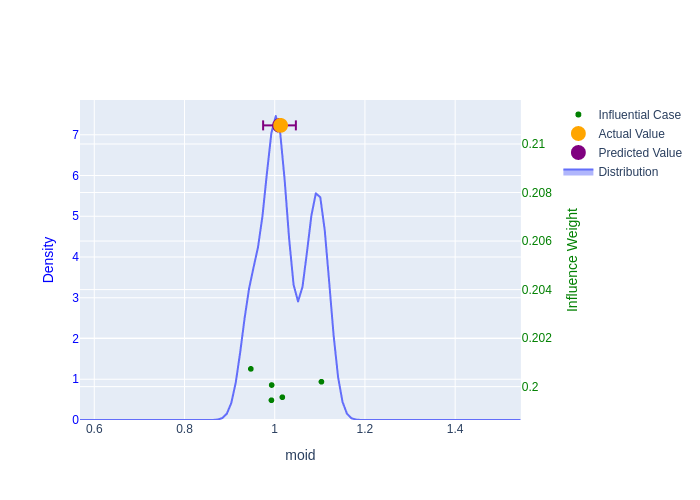

In [10]:
plot_interpretable_prediction(
    react,
    actual_value=action_value,
    generative_reacts=gen_reacts,
    residual=local_residual,
)

This visualization show us the probability density of the action feature value given the context as well as the values of the influential cases and their corresponding influence weights. All of this information is at the core of how the Howso Engine makes its predictions, which should elucidate the information that is used when the Trainee makes a prediction.

## Step 7: Use a non-visual interpretation

Howso Engine provides a number of tools for interpreting reacts. Below, we compare the MDA (Mean Decrease in Accuracy) for the predicted case and the original case. Inspecting the difference between these MDA values can indicate to the user how much the local model changes when the action feature and value become part of the context that determines the influential cases.

> Reminder: The "local model" is the region of the data surrounding a prediction made up by its influential cases. In contrast, the entire dataset can be referred to as the "global model".

In [11]:
react = trainee.react(context_features=context_features,
                      action_features=action_feature,
                      contexts=[context_values],
                      details = {
                         'feature_mda': True,
                         'robust_influences': True
                      })

loc_mda = react['details']['feature_mda']

mda_dict = dict(sorted(loc_mda[0].items(), key=lambda item: item[1], reverse=True))
mda_df = pd.DataFrame(columns=['original', 'predicted'])
mda_df['predicted'] = mda_dict.values()
mda_df.index = mda_dict.keys()

react2 = trainee.react(context_features=context_features,
                       action_features=action_feature,
                       actions=[[action_value]],  # specify "actual" actual value
                       contexts=[context_values],
                       details = {
                           'feature_mda_ex_post': True,
                           'robust_influences': True
                       })

loc_mda_post_facto = react2['details']['feature_mda_ex_post']
mda_dict = dict(sorted(loc_mda_post_facto[0].items(), key=lambda item: item[1], reverse=True))
mda_df['original'] = mda_dict.values()

display(mda_df)

,original,predicted
rot_per,0.027356,0.056586
w,0.025930,0.030756
a,0.024529,0.028326
n_obs_used,0.024167,0.026283
H,0.016203,0.026119
GM,0.014585,0.025742
q,0.012029,0.022467
per_y,0.009028,0.021831
e,0.008255,0.018950
spec_T,0.005466,0.017762


# Conclusion

This recipe further demonstrates the interpretability tools available to users alongside their predictions with the `react` call. When using a series of generative `react`'s alongside the discriminative `react` used for the prediction, users can visualize the probability distribution of the action feature given the specific context. Additionally, users can see the exact cases from the training data that were used to make the prediction.

This interpretability is crucial for many machine learning use-cases whether it be safety-critical applicaitons or any other model that can directly impact the lives of those affected by its decisions. Without interpretability, users must blindly accept model predictions which can often lead to incorrect predictions severely impacting people in often disproportional ways. The ability to maintain accuracy while providing full interpretability is at the core of the Howso Engine's design.